In [1]:
'''
TORCWA Example6
Topology optimization - Maximize 1st order diffraction

'''
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Import
import numpy as np
import torch
import scipy.io
from matplotlib import pyplot as plt
import time

import torcwa
import Materials

# Hardware
# If GPU support TF32 tensor core, the matmul operation is faster than FP32 but with less precision.
# If you need accurate operation, you have to disable the flag below.
torch.backends.cuda.matmul.allow_tf32 = False
sim_dtype = torch.complex64
geo_dtype = torch.float32
device = torch.device('cuda')

# Simulation environment
# light
lamb0 = torch.tensor(532.,dtype=geo_dtype,device=device)    # nm
inc_ang = 0.*(np.pi/180)    # radian
azi_ang = 0.*(np.pi/180)    # radian

# material
substrate_eps = 1.46**2
silicon_eps = Materials.aSiH.apply(lamb0)**2

# geometry
L = [700., 300.]            # nm / nm
torcwa.rcwa_geo.dtype = geo_dtype
torcwa.rcwa_geo.device = device
torcwa.rcwa_geo.Lx = L[0]
torcwa.rcwa_geo.Ly = L[1]
torcwa.rcwa_geo.nx = 700
torcwa.rcwa_geo.ny = 300
torcwa.rcwa_geo.grid()
torcwa.rcwa_geo.edge_sharpness = 1000.

x_axis = torcwa.rcwa_geo.x.cpu()
y_axis = torcwa.rcwa_geo.y.cpu()

# layers
layer0_thickness = 300.

In [2]:
# Objective function
def objective_function(rho):
    order = [15,8]

    sim = torcwa.rcwa(freq=1/lamb0,order=order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    layer0_eps = rho*silicon_eps + (1.-rho)
    sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
    sim.solve_global_smatrix()
    t1xx = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t1yy = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t1xy = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t1yx = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T1_sum = torch.abs(t1xx)**2 + torch.abs(t1yy)**2 + torch.abs(t1xy)**2 + torch.abs(t1yx)**2
    return T1_sum

In [3]:
# Perform optimization
# optimizer parameters for ADAM optimizer
iter_max = 800
beta = np.exp(np.arange(start=0,stop=iter_max)*np.log(1000)/iter_max)

# blur kernel
blur_radius = 20.
dx, dy = L[0]/torcwa.rcwa_geo.nx, L[1]/torcwa.rcwa_geo.ny
x_kernel_axis = (torch.arange(torcwa.rcwa_geo.nx,dtype=geo_dtype,device=device)-(torcwa.rcwa_geo.nx-1)/2)*dx
y_kernel_axis = (torch.arange(torcwa.rcwa_geo.ny,dtype=geo_dtype,device=device)-(torcwa.rcwa_geo.ny-1)/2)*dy
x_kernel_grid, y_kernel_grid = torch.meshgrid(x_kernel_axis,y_kernel_axis,indexing='ij')
g = torch.exp(-(x_kernel_grid**2+y_kernel_grid**2)/blur_radius**2)
g = g/torch.sum(g)
g_fft = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(g)))

torch.manual_seed(333)
rho = torch.rand((torcwa.rcwa_geo.nx,torcwa.rcwa_geo.ny),dtype=geo_dtype,device=device)

#is it needed?
rho = (rho + torch.fliplr(rho))/2
rho_fft = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(rho)))
rho = torch.real(torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(rho_fft*g_fft))))
#

In [4]:
rho.requires_grad_(True)
optimizer = torch.optim.Adam([rho], lr = 0.001)

In [5]:
def rho_preprocess(rho):
    rho = rho.clip(0,1)
    rho = (rho + torch.fliplr(rho))/2
    return rho

In [6]:
rho_history = []
FoM_history = []

start_time = time.time()
for it in range(0,iter_max):
    preprocessed_rho = rho_preprocess(rho)
    rho_fft = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(preprocessed_rho)))

    rho_bar = torch.real(torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(rho_fft*g_fft))))
    rho_tilda = 1/2 + torch.tanh(2*beta[it]*rho_bar-beta[it])/(2*np.math.tanh(beta[it]))
    FoM = objective_function(rho_tilda)
    
    optimizer.zero_grad()
    (-FoM).backward() #gradient ascent
    optimizer.step()
    
    rho_history.append(rho_tilda.detach().cpu().numpy())
    FoM_history.append(float(FoM.detach().cpu().numpy()))
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print('Iteration:',it,'/ FoM:',int(FoM*10000)/10000,'/ Elapsed time:',str(int(elapsed_time))+' s')

Iteration: 0 / FoM: 0.0 / Elapsed time: 2 s
Iteration: 1 / FoM: 0.0001 / Elapsed time: 4 s
Iteration: 2 / FoM: 0.0003 / Elapsed time: 5 s
Iteration: 3 / FoM: 0.0006 / Elapsed time: 7 s
Iteration: 4 / FoM: 0.0009 / Elapsed time: 8 s
Iteration: 5 / FoM: 0.0014 / Elapsed time: 10 s
Iteration: 6 / FoM: 0.002 / Elapsed time: 11 s
Iteration: 7 / FoM: 0.0026 / Elapsed time: 13 s
Iteration: 8 / FoM: 0.0034 / Elapsed time: 15 s
Iteration: 9 / FoM: 0.0044 / Elapsed time: 17 s
Iteration: 10 / FoM: 0.0054 / Elapsed time: 19 s
Iteration: 11 / FoM: 0.0066 / Elapsed time: 20 s
Iteration: 12 / FoM: 0.0079 / Elapsed time: 22 s
Iteration: 13 / FoM: 0.0094 / Elapsed time: 24 s
Iteration: 14 / FoM: 0.011 / Elapsed time: 26 s
Iteration: 15 / FoM: 0.0128 / Elapsed time: 28 s
Iteration: 16 / FoM: 0.0148 / Elapsed time: 30 s
Iteration: 17 / FoM: 0.0169 / Elapsed time: 31 s
Iteration: 18 / FoM: 0.0193 / Elapsed time: 33 s
Iteration: 19 / FoM: 0.0218 / Elapsed time: 35 s
Iteration: 20 / FoM: 0.0246 / Elapsed ti

Iteration: 165 / FoM: 0.9829 / Elapsed time: 227 s
Iteration: 166 / FoM: 0.9851 / Elapsed time: 228 s
Iteration: 167 / FoM: 0.9872 / Elapsed time: 229 s
Iteration: 168 / FoM: 0.9894 / Elapsed time: 231 s
Iteration: 169 / FoM: 0.9916 / Elapsed time: 232 s
Iteration: 170 / FoM: 0.9938 / Elapsed time: 233 s
Iteration: 171 / FoM: 0.9961 / Elapsed time: 234 s
Iteration: 172 / FoM: 0.9983 / Elapsed time: 236 s
Iteration: 173 / FoM: 1.0005 / Elapsed time: 237 s
Iteration: 174 / FoM: 1.0028 / Elapsed time: 238 s
Iteration: 175 / FoM: 1.005 / Elapsed time: 239 s


KeyboardInterrupt: 

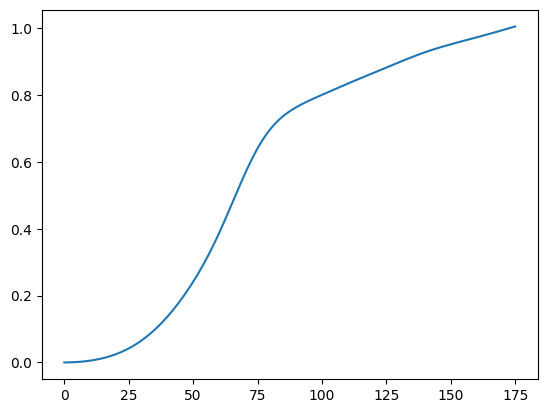

In [7]:
plt.plot(np.array(FoM_history))

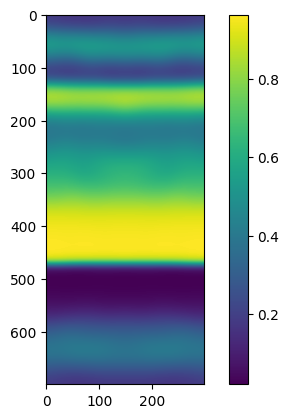

In [8]:
# Export data
filename = 'Example6_data.mat'
ex6_data = {'rho_history':rho_history,'FoM_history':FoM_history}
scipy.io.savemat(filename,ex6_data)

# Plot
plt.imshow(rho_tilda.detach().cpu().numpy())
plt.colorbar()

In [9]:
# Field calculation
z = torch.linspace(-500,1500,501,device=device)
z_axis = z.cpu()

rho_fft = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(rho)))
rho_bar = torch.real(torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(rho_fft*g_fft))))
rho_tilda = 1/2 + torch.tanh(2*beta[-1]*rho.detach()-beta[-1])/(2*np.math.tanh(beta[-1]))

order = [15,8]

sim = torcwa.rcwa(freq=1/lamb0,order=order,L=L,dtype=sim_dtype,device=device)
sim.add_input_layer(eps=substrate_eps)
sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
layer0_eps = rho_tilda*silicon_eps + (1.-rho_tilda)
sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
sim.solve_global_smatrix()

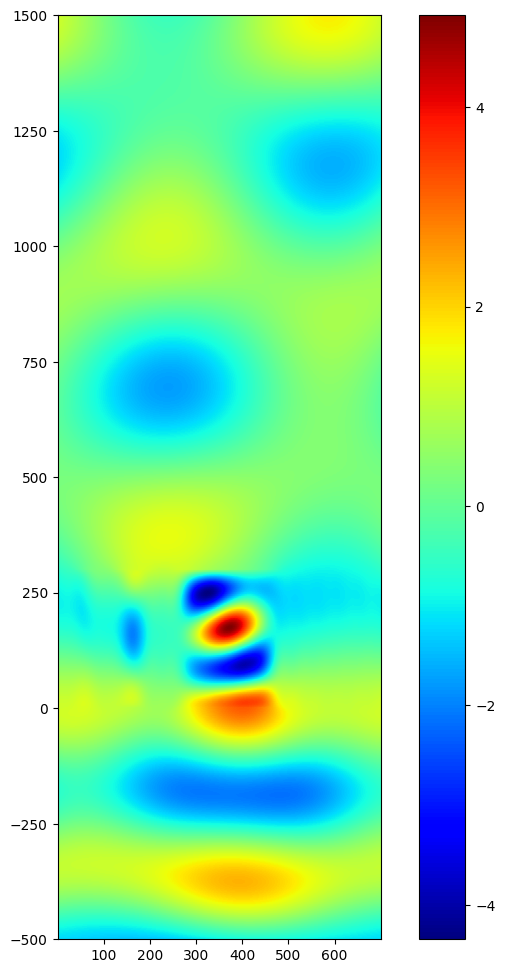

In [10]:
# View XZ-plane fields and export for x-pol input
sim.source_planewave(amplitude=[1.,0.],direction='forward')
[Ex, Ey, Ez], [Hx, Hy, Hz] = sim.field_xz(torcwa.rcwa_geo.x,z,L[1]/2)
Enorm = torch.sqrt(torch.abs(Ex)**2 + torch.abs(Ey)**2 + torch.abs(Ez)**2)
Hnorm = torch.sqrt(torch.abs(Hx)**2 + torch.abs(Hy)**2 + torch.abs(Hz)**2)

plt.figure(figsize=(10,12))
plt.imshow(torch.transpose(torch.real(Hy),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
plt.colorbar()

ex6_Xpol_data = {'x_axis':x_axis.numpy(),'y_axis':y_axis.numpy(),'z_axis':z_axis.numpy(),\
    'Ex':Ex.cpu().numpy(),'Ey':Ey.cpu().numpy(),'Ez':Ez.cpu().numpy(),'Enorm':Enorm.cpu().numpy(),\
    'Hx':Hx.cpu().numpy(),'Hy':Hy.cpu().numpy(),'Hz':Hz.cpu().numpy(),'Hnorm':Hnorm.cpu().numpy()}
scipy.io.savemat('Example6_Xpol_data.mat',ex6_Xpol_data)

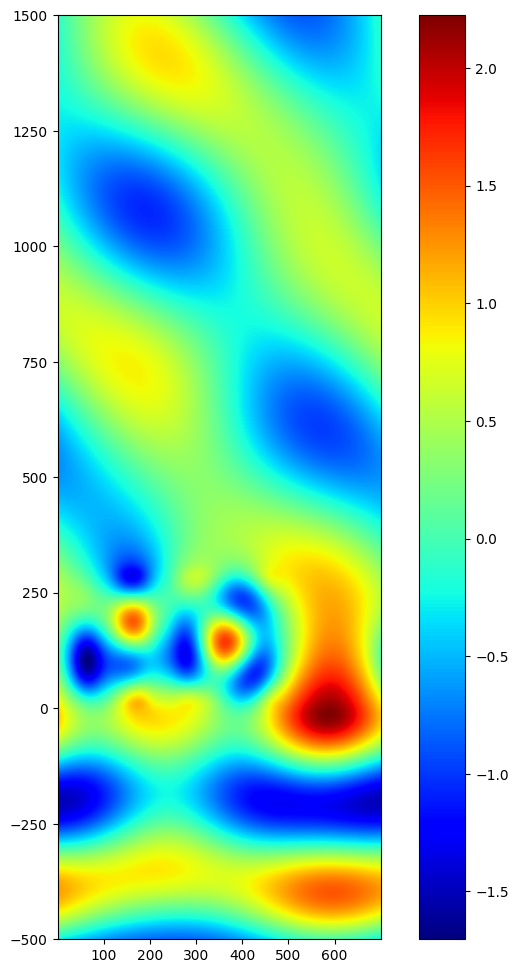

In [11]:
# View XZ-plane fields and export for x-pol input
sim.source_planewave(amplitude=[0.,1.],direction='forward')
[Ex, Ey, Ez], [Hx, Hy, Hz] = sim.field_xz(torcwa.rcwa_geo.x,z,L[1]/2)
Enorm = torch.sqrt(torch.abs(Ex)**2 + torch.abs(Ey)**2 + torch.abs(Ez)**2)
Hnorm = torch.sqrt(torch.abs(Hx)**2 + torch.abs(Hy)**2 + torch.abs(Hz)**2)

plt.figure(figsize=(10,12))
plt.imshow(torch.transpose(torch.real(Ey),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
plt.colorbar()

ex6_Ypol_data = {'x_axis':x_axis.numpy(),'y_axis':y_axis.numpy(),'z_axis':z_axis.numpy(),\
    'Ex':Ex.cpu().numpy(),'Ey':Ey.cpu().numpy(),'Ez':Ez.cpu().numpy(),'Enorm':Enorm.cpu().numpy(),\
    'Hx':Hx.cpu().numpy(),'Hy':Hy.cpu().numpy(),'Hz':Hz.cpu().numpy(),'Hnorm':Hnorm.cpu().numpy()}
scipy.io.savemat('Example6_Ypol_data.mat',ex6_Ypol_data)